In [1]:
import os
import numpy as np
from pyrecode.recode_reader import ReCoDeReader
import queue
import matplotlib.pyplot as plt

In [23]:
class ReCoDeViewer():

    def __init__(self, folder_path, base_filename, num_parts, fractionation):
        
        self._num_parts = num_parts
        self._fractionation = fractionation

        self._readers = {}
        for index in range(num_parts):
            intermediate_file_name = os.path.join(folder_path, base_filename + '_part' + '{0:03d}'.format(index))
            self._readers[index] = ReCoDeReader(intermediate_file_name, is_intermediate=True)
            self._readers[index].open()
        self._ny = self._readers[0]._get_shape()[1]
        self._nx = self._readers[0]._get_shape()[2]

        self._view = None
        self._frame_start = 0
        self._buffer = {}
        for index in range(fractionation):
            self._buffer[index] = queue.Queue(maxsize=fractionation)

    
    def _get_next_frame_safely (self, reader_index):
        '''
        performs a get only if there is enough data ahead, ensuring that EoF is not reached after get
        returns None if enough data is not available. In this case, pointer is not moved, and another attempt to read the frame may be made in the next pass
        '''
        # d = self._readers[reader_index]._get_next_frame_safely()
        d = self._readers[reader_index]._get_next_frame()
        return d

    
    def get_next_view (self):

        # attempt to fill queues
        for index in range(self._num_parts):
            for t in range(self._fractionation - self._buffer[index].qsize()):
                d = self._get_next_frame_safely(index)
                if d is not None:
                    self._buffer[index].put(d)
                else:
                    break

        # temporary holder of fractionation frames
        temp = {}

        # try to fill temp with 'fractionation' frames, if enough frames are not available
        for _fid in range(self._frame_start, self._frame_start+self._fractionation):
            for index in range(self._num_parts):
                for i in range(self._buffer[index].qsize()):
                    if _fid in self._buffer[index].queue[0]:            # Assumes frames are in ascending order within a part file
                        temp.update(self._buffer[index].get())          # Assumes there are no duplicate frames

        if len(temp) < self._fractionation:
            print("Warning: read fewer frames (" + str(len(temp)) + ") than requested (" + str(self._fractionation) + ").")

        self._view = np.zeros((self._nx,self._ny))
        for frame_id in temp:
            if temp[frame_id] is not None:
                self._view = np.add(self._view, temp[frame_id].toarray())

        ret_val = {'start': self._frame_start, 'n_Frames': len(temp), 'view': self._view}
        
        # next frame_start
        self._frame_start = np.max(list(temp.keys())) + 1

        return ret_val
    
    
    def close(self):
        for index in range(self._num_parts):
            self._readers[index].close()

uid = 255
version_major = 0
version_minor = 1
reduction_level = 1
recode_operation_mode = 1
bit_depth = 12
nx = 1024
ny = 1024
nz = 1790
L2_statistics = 0
L4_centroiding = 0
compression_scheme = 0
compression_level = 1
source_file_type = 2
source_header_length = 0
source_header_position = 1
source_file_name = gold_nano_1k_1k                                                                                     
dark_file_name = _dark_ref_2.bin                                                                                     
dark_threshold_epsilon = 20
has_dark_data = 1
frame_offset = 0
dark_frame_offset = 0
num_dark_frames = 1
source_bit_depth = 12
checksum = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
futures = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
uid = 255
version_major = 0
version_minor = 1
reduction_level = 1
recode_operation_mode = 1
bit_depth = 12
nx = 1024
ny = 1024
nz = 1790
L2_statistics = 0
L4_centroi

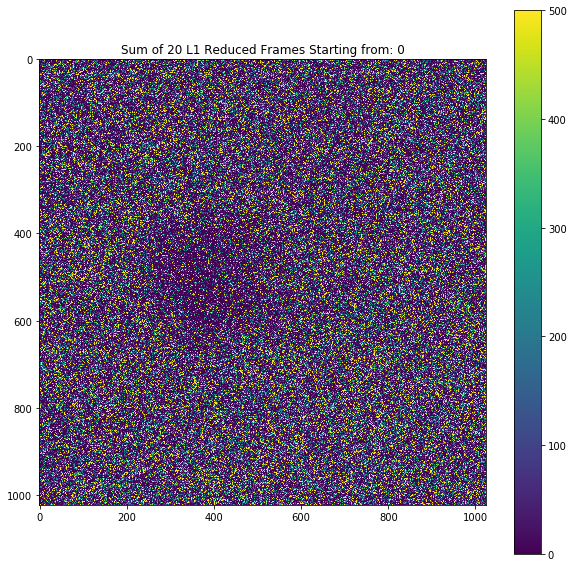

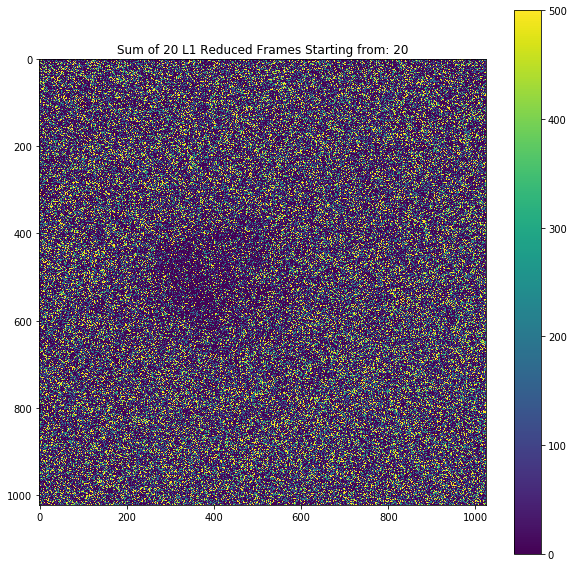

In [22]:
_data_folder = '/scratch/loh/abhik/23-Jan-2020'
_dataset = 'gold_nano_1k_1k_dr=0.03'
_tag = 'gold_nano_1k_1k'
_num_part_files = 12
_fractionation = 20

viewer = ReCoDeViewer(os.path.join(_data_folder, _dataset), _tag + '.rc1', _num_part_files, _fractionation)
for i in range(2):
    v = viewer.get_next_view()
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(v['view'], vmax=500)
    ax.set(title='Sum of ' + str(v['n_Frames']) + ' L1 Reduced Frames Starting from: ' + str(v['start']))
    fig.colorbar(im)
    plt.show()
viewer.close()